In [9]:
file_path = "archive/ultrasound breast classification/train/benign/benign (36)-rotated1-rotated2.png"
image_path = file_path


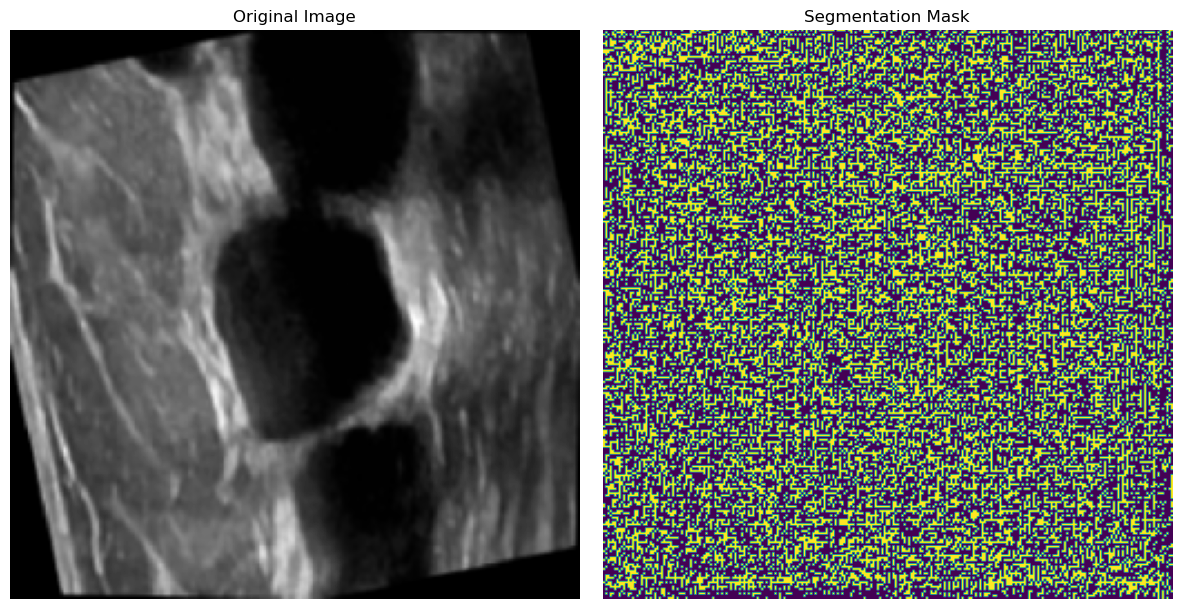

In [16]:
import torch
import monai
from monai.transforms import (
    Compose,
    EnsureChannelFirst,
    ScaleIntensity,
    Resize,
    ToTensor,
    Lambda,
    LoadImage
)
import os
from monai.networks.nets import UNet
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Set deterministic training for reproducibility
set_determinism(seed=0)

def rgb_to_grayscale(image):
    if image.shape[0] == 3:  # If it's an RGB image
        return torch.mean(image, dim=0, keepdim=True)
    return image  # If it's already grayscale, return as is


# Load and preprocess the image
def preprocess_image(image_path):
    
    # Define preprocessing transforms
    preprocess = Compose([
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        Resize((256, 256)),
        Lambda(rgb_to_grayscale),
        ToTensor()
    ])
    
    return preprocess(image_path)

# Create a simple dataset
class SimpleDataset(Dataset):
    def __init__(self, image):
        self.image = image
    
    def __len__(self):
        return 1
    
    def __getitem__(self, index):
        return self.image

# Set up the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=10,
).to(device)

# Load and preprocess the image
preprocessed_image = preprocess_image(image_path)

# Create dataset and dataloader
dataset = SimpleDataset(preprocessed_image)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Perform inference
model.eval()
with torch.no_grad():
    for batch in dataloader:
        batch = batch.to(device)
        outputs = model(batch)
        segmentation = torch.argmax(outputs, dim=1).squeeze().cpu().numpy()

# Visualize results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(preprocessed_image.squeeze(), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmentation, cmap='viridis')
plt.title('Segmentation Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
import torch
import monai
from monai.transforms import (
    Compose,
    EnsureChannelFirst,
    ScaleIntensity,
    Resize,
    LoadImage,
    RandRotate90,
    RandFlip,
    RandZoom,
    RandGaussianNoise,
    ToTensor,
    Lambda
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# Set deterministic training for reproducibility
set_determinism(seed=0)

def rgb_to_grayscale(image):
    if image.shape[0] == 3:  # If it's an RGB image
        return torch.mean(image, dim=0, keepdim=True)
    return image  # If it's already grayscale, return as is

# Load and preprocess the image
def preprocess_image(image_path, is_training=False):

    # Define preprocessing transforms
    if is_training:
        preprocess = Compose([
            LoadImage(image_only=True),
            EnsureChannelFirst(),
            ScaleIntensity(),
            Resize((256, 256)),
            Lambda(rgb_to_grayscale),
            ToTensor()
        ])
    else:
        preprocess = Compose([
            LoadImage(image_only=True),
            EnsureChannelFirst(),
            ScaleIntensity(),
            Resize((256, 256)),
            Lambda(rgb_to_grayscale),
            ToTensor()
        ])
    
    return preprocess(image_path)

# Create a simple dataset
class SimpleDataset(Dataset):
    def __init__(self, image_paths, is_training=False):
        self.image_paths = image_paths
        self.is_training = is_training
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        return preprocess_image(self.image_paths[index], self.is_training)

# Set up the improved UNet model
def get_unet_model(in_channels=1, out_channels=2):
    return UNet(
        spatial_dims=2,
        in_channels=in_channels,
        out_channels=out_channels,
        channels=(32, 64, 128, 256, 512),
        strides=(2, 2, 2, 2),
        num_res_units=3,
        dropout=0.2
    )

# Training function
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_data in train_loader:
            inputs, targets = batch_data.to(device), batch_data.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for val_data in val_loader:
                val_inputs, val_targets = val_data.to(device), val_data.to(device)
                val_outputs = model(val_inputs)
                val_loss += loss_function(val_outputs, val_targets).item()
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    return model



In [9]:
# Main execution
# if __name__ == "__main__":
    # Assuming you have a set of similar images for training
train_image = "archive/ultrasound breast classification/train/benign"
val_image = "archive/ultrasound breast classification/val/benign"


train_image_paths = [os.path.join(train_image, i) for i in os.listdir(train_image) if i.endswith(".png")]
val_image_paths = [os.path.join(val_image, i) for i in os.listdir(val_image) if i.endswith(".png")]
# Create datasets and dataloaders

# train_image_paths = [""]
# val_image_paths = ["path_to_val_image1.png", "path_to_val_image2.png", ...]

# Create datasets and dataloaders
train_dataset = SimpleDataset(train_image_paths, is_training=True)
val_dataset = SimpleDataset(val_image_paths, is_training=False)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Initialize and train the model
model = get_unet_model()
trained_model = train_model(model, train_loader, val_loader)

Epoch 1/10, Train Loss: 406.8634, Val Loss: 59.0211
Epoch 2/10, Train Loss: 371.8676, Val Loss: 52.8488


In [25]:
trained_model

NameError: name 'trained_model' is not defined

In [24]:
# Load and preprocess the test image
test_image_path = "archive/ultrasound breast classification/val/benign/benign (35)-rotated2-rotated2.png"
test_image = preprocess_image(test_image_path)

# Perform inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model.eval()
with torch.no_grad():
    test_input = test_image.unsqueeze(0).to(device)
    test_output = trained_model(test_input)
    segmentation = torch.argmax(test_output, dim=1).squeeze().cpu().numpy()

# Visualize results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(test_image.squeeze(), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmentation, cmap='viridis')
plt.title('Segmentation Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

NameError: name 'trained_model' is not defined